In [1]:
import sys
from pathlib import Path

# Add src to path
src_path = Path.cwd().parent / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Paper replication I : Simulation

Simulation of a spread to include in the paper: "We simulate a synthetic spread as a noisy, mean-reverting stochastic process around a fixed equilibrium level, so that threshold-based trading strategies can be illustrated independently of real data."

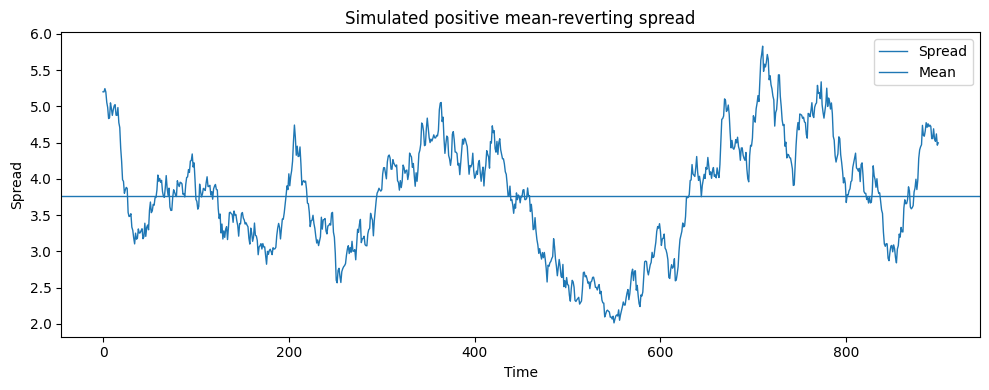

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_cir_spread(
    n=800, dt=1/252, s0=5.0, kappa=3.0, theta=5.0, sigma=0.9, seed=42
):
    """
    Positive mean-reverting spread around theta using CIR:
      dS = kappa(theta - S) dt + sigma sqrt(S) dW
    Full-truncation Euler to keep it >= 0 numerically.
    """
    rng = np.random.default_rng(seed)
    S = np.empty(n)
    S[0] = s0
    for t in range(1, n):
        z = rng.standard_normal()
        s_pos = max(S[t-1], 0.0)  # truncation for sqrt
        S[t] = S[t-1] + kappa*(theta - s_pos)*dt + sigma*np.sqrt(s_pos)*np.sqrt(dt)*z
        S[t] = max(S[t], 0.0)     # enforce non-negativity
    return S

# --- generate fake spread ---
S = simulate_cir_spread(n=900, dt=1/252, s0=5.2, kappa=2.5, theta=5.0, sigma=1.1, seed=7)

mu = np.mean(S)

# --- plot like the paper: mean + constant bands ---

plt.figure(figsize=(10,4))
plt.plot(S, lw=1, label="Spread")
plt.axhline(mu, lw=1, label="Mean")
plt.title("Simulated positive mean-reverting spread")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.legend()
plt.tight_layout()
plt.show()

## Benchmark trading strategies

In [3]:
from pairs_ssm.trading.strategy import (
    strategy_A_signals, 
    strategy_B_signals, 
    find_trades,      # For Strategy A and C
    find_trades_B,    # For Strategy B
)

S = pd.Series(S, index=range(len(S)))

We will use the standard trading rule I to define the different tresholds (model (2) is linear mean reverting, homoscedastic, and Gaussian)

In [4]:
sigma = np.std(S)

k = 1 #nb of std 
U = mu + k*sigma
L = mu - k*sigma
C = mu
print(C)

3.7633821770586695


### Trading Strategy A 

In [5]:
signals_A = strategy_A_signals(S, U=U, L=L, C=C)
trades_A = find_trades(signals_A)

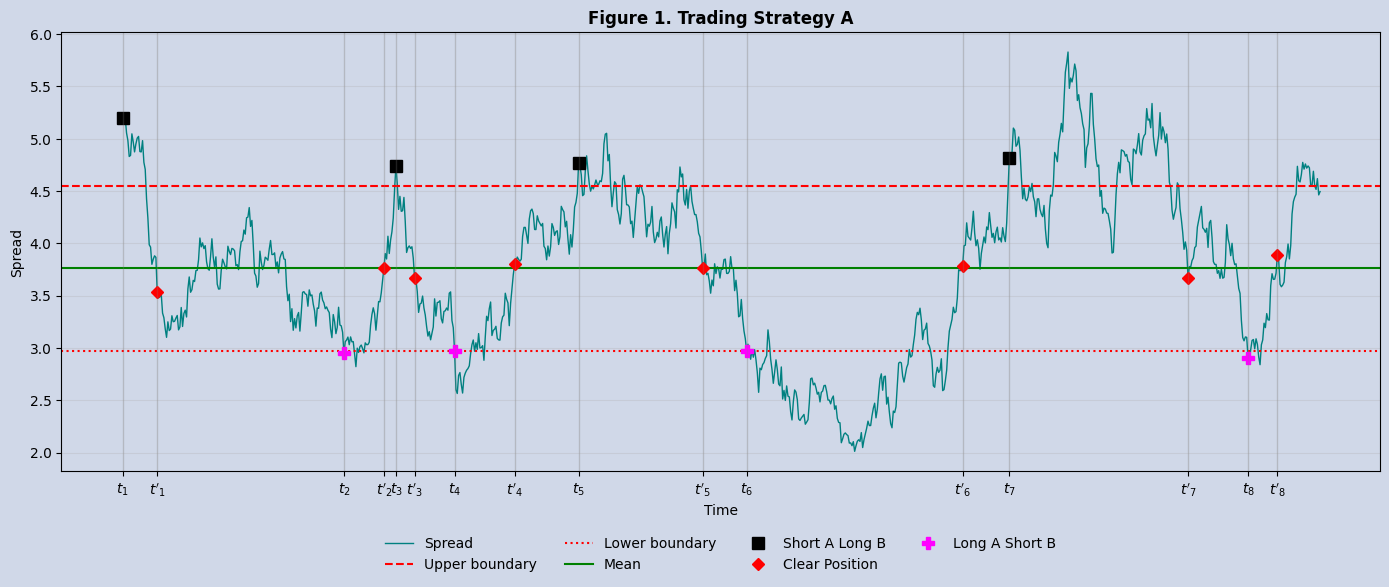

In [6]:
import matplotlib.pyplot as plt

# --- compute signals/trades ---
signals_A = strategy_A_signals(S, U=U, L=L, C=C)
trades_A  = find_trades(signals_A)

# --- Plot Figure 1: Strategy A (legend like the paper) ---
fig, ax = plt.subplots(figsize=(14, 6), facecolor='#d0d8e8')
ax.set_facecolor('#d0d8e8')

# Spread
ax.plot(S.index, S.values, color='teal', linewidth=1, label='Spread')

# Thresholds
ax.axhline(y=U, color='red', linestyle='--', linewidth=1.5, label='Upper boundary')
ax.axhline(y=L, color='red', linestyle=':',  linewidth=1.5, label='Lower boundary')
ax.axhline(y=C, color='green', linestyle='-', linewidth=1.5, label='Mean')

# Mark entry/exit points with paper symbols + robust legend labels
shown_short = False
shown_long  = False
shown_clear = False

# Build x-axis tick labels: t1, t1', t2, t2', ...
tick_pos, tick_lab = [], []

for i, trade in enumerate(trades_A[:8], start=1):
    entry = trade['entry']
    exit_ = trade['exit']

    entry_val = S.loc[entry]
    exit_val  = S.loc[exit_]

    # Entry markers
    if trade['type'] == 'short':
        # ■ Short A Long B
        ax.plot(entry, entry_val, marker='s', linestyle='None', color='black',
                markersize=8, label='Short A Long B' if not shown_short else '')
        shown_short = True
    else:
        # ✚ Long A Short B (purple cross)
        ax.plot(entry, entry_val, marker='P', linestyle='None', color='magenta',
                markersize=8, label='Long A Short B' if not shown_long else '')
        shown_long = True

    # Exit marker: ◆ Clear Position
    ax.plot(exit_, exit_val, marker='D', linestyle='None', color='red',
            markersize=6, label='Clear Position' if not shown_clear else '')
    shown_clear = True

    # Optional: vertical lines at entry/exit (paper-like)
    ax.axvline(entry, color='grey', alpha=0.25, linewidth=1)
    ax.axvline(exit_, color='grey', alpha=0.25, linewidth=1)

    # Custom ticks
    tick_pos += [entry, exit_]
    tick_lab += [rf"$t_{i}$", rf"$t'_{i}$"]

# Replace x-axis with t_i / t'_i
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_lab)

# Titles/labels
ax.set_title('Figure 1. Trading Strategy A', fontsize=12, fontweight='bold')
ax.set_xlabel('Time')
ax.set_ylabel('Spread')

# Legend (deduplicate labels)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          loc='upper center', bbox_to_anchor=(0.5, -0.12),
          ncol=4, frameon=False)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Trading Strategy B

In [7]:
# Apply Strategy B
signals_B = strategy_B_signals(S, U=U, L=L)

# Find trades using module function (B flips positions directly)
trades_B = find_trades_B(signals_B)

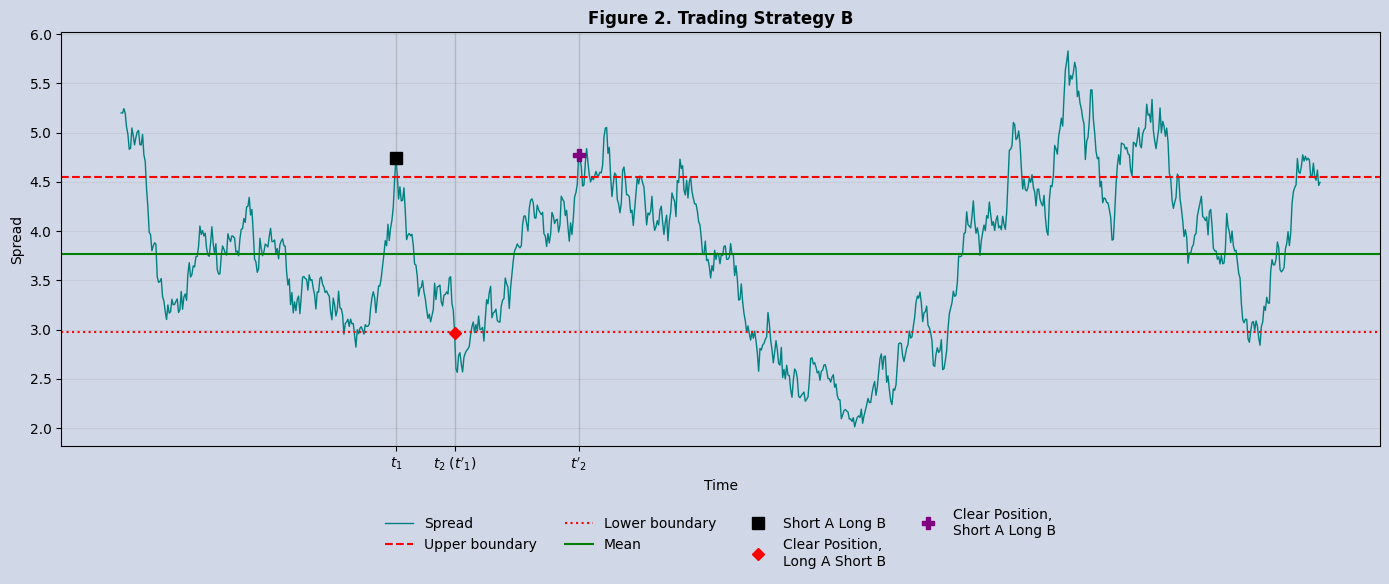

Chosen paper-like events:
t1   = 206   (up-cross U)   S=4.7410
t2=t1' = 250 (down-cross L) S=2.9684
t2'  = 343  (up-cross U)   S=4.7695


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# --- Helper: find first crossing index after a start ---
def first_cross_up(series, level, start=1):
    # prev < level and curr >= level
    x = series.values
    idx = series.index
    for t in range(max(1, start), len(x)):
        if x[t-1] < level and x[t] >= level:
            return idx[t]
    return None

def first_cross_down(series, level, start=1):
    # prev > level and curr <= level
    x = series.values
    idx = series.index
    for t in range(max(1, start), len(x)):
        if x[t-1] > level and x[t] <= level:
            return idx[t]
    return None

# --- 1) Pick the 3 “paper-like” events from YOUR data ---
# t1: cross up through U
t1 = first_cross_up(S, U, start=1)
if t1 is None:
    raise ValueError("No up-crossing of U found (t1). Try different U or longer sample.")

# position in integer location
t1_loc = S.index.get_loc(t1)

# t2 (= t1'): next cross down through L after t1
t2 = first_cross_down(S, L, start=t1_loc+1)
if t2 is None:
    raise ValueError("No down-crossing of L found after t1 (t2=t1').")

t2_loc = S.index.get_loc(t2)

# t2': next cross up through U after t2
t2p = first_cross_up(S, U, start=t2_loc+1)
if t2p is None:
    raise ValueError("No next up-crossing of U found after t2 (t2').")

# Values at those times
S_t1  = S.loc[t1]
S_t2  = S.loc[t2]
S_t2p = S.loc[t2p]

# --- 2) Plot (replicate paper layout) ---
fig, ax = plt.subplots(figsize=(14, 6), facecolor='#d0d8e8')
ax.set_facecolor('#d0d8e8')

# Spread + thresholds
ax.plot(S.index, S.values, color='teal', linewidth=1, label='Spread')
ax.axhline(y=U, color='red', linestyle='--', linewidth=1.5, label='Upper boundary')
ax.axhline(y=L, color='red', linestyle=':',  linewidth=1.5, label='Lower boundary')
ax.axhline(y=C, color='green', linestyle='-', linewidth=1.5, label='Mean')

# Vertical lines at key times (paper-like)
for xline in [t1, t2, t2p]:
    ax.axvline(xline, color='grey', alpha=0.25, linewidth=1)

# --- 3 markers exactly as you requested ---
# t1: black square (Short A Long B)
ax.plot(t1, S_t1, marker='s', linestyle='None', color='black', markersize=8,
        label='Short A Long B')

# t1' == t2: red diamond (Clear Position, Long A Short B)
ax.plot(t2, S_t2, marker='D', linestyle='None', color='red', markersize=6,
        label='Clear Position,\nLong A Short B')

# t2': purple cross (Clear Position, Short A Long B)
ax.plot(t2p, S_t2p, marker='P', linestyle='None', color='purple', markersize=8,
        label='Clear Position,\nShort A Long B')

# --- x-axis ticks like the paper ---
ax.set_xticks([t1, t2, t2p])
ax.set_xticklabels([r"$t_1$", r"$t_2\;(t'_1)$", r"$t'_2$"])

ax.set_title("Figure 2. Trading Strategy B", fontsize=12, fontweight='bold')
ax.set_xlabel("Time")
ax.set_ylabel("Spread")

# Legend: deduplicate (paper style)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          loc='upper center', bbox_to_anchor=(0.5, -0.12),
          ncol=4, frameon=False)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Chosen paper-like events:")
print(f"t1   = {t1}   (up-cross U)   S={S_t1:.4f}")
print(f"t2=t1' = {t2} (down-cross L) S={S_t2:.4f}")
print(f"t2'  = {t2p}  (up-cross U)   S={S_t2p:.4f}")


## The New trading strategy

In [9]:
from pairs_ssm.trading.strategy import strategy_C_signals
from pairs_ssm.trading.strategy import strategy_C_signals_timevarying

On passe a la strat C

In [10]:
signals_C = strategy_C_signals(S, U=U, L=L, C=C)
trades_C = find_trades(signals_C)

### homoscedastic model

In [11]:
# pick your blue lines as indices (change these two numbers)
i0, i1 = 200, 520   # <-- YOU SET THESE

S_win = S.iloc[i0:i1]
sig_win = signals_C.loc[S_win.index]  # align
trades_win = find_trades(sig_win)


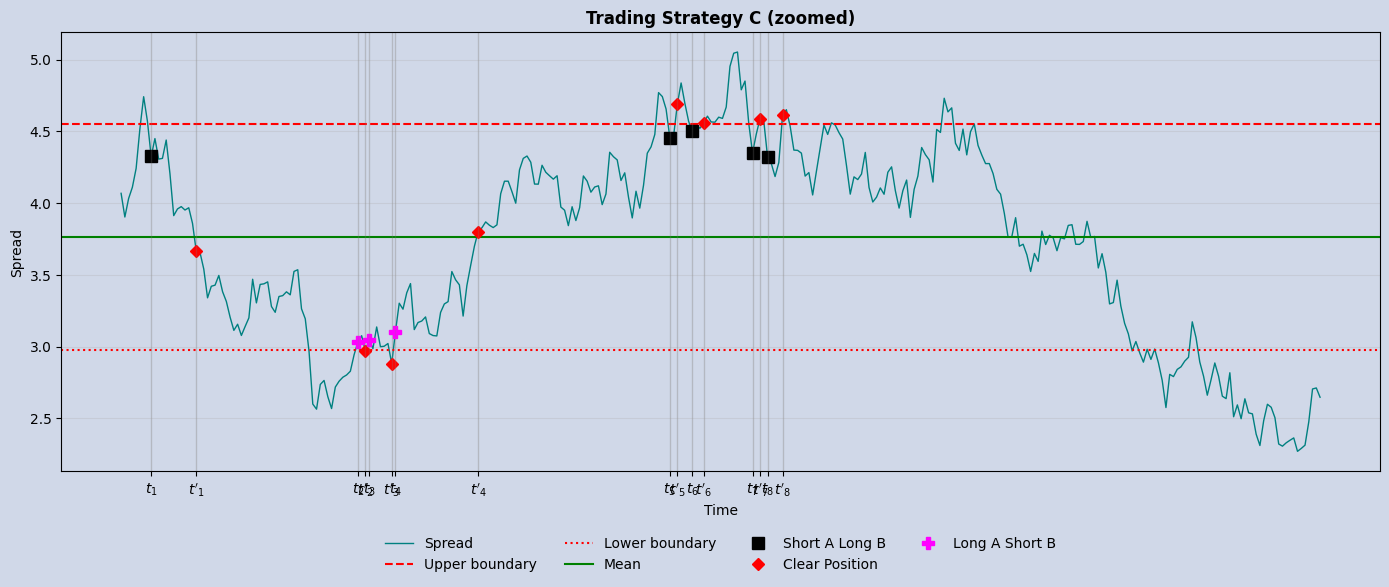

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6), facecolor='#d0d8e8')
ax.set_facecolor('#d0d8e8')

# Spread in window
ax.plot(S_win.index, S_win.values, color='teal', linewidth=1, label='Spread')

# Thresholds
ax.axhline(y=U, color='red', linestyle='--', linewidth=1.5, label='Upper boundary')
ax.axhline(y=L, color='red', linestyle=':',  linewidth=1.5, label='Lower boundary')
ax.axhline(y=C, color='green', linestyle='-', linewidth=1.5, label='Mean')

# Markers (only trades fully inside the window)
shown_short = shown_long = shown_clear = False
tick_pos, tick_lab = [], []

K = min(8, len(trades_win))

for i, tr in enumerate(trades_win[:K], start=1):
    entry, exit_ = tr["entry"], tr["exit"]
    entry_val = S_win.loc[entry]
    exit_val  = S_win.loc[exit_]

    if tr["type"] == "short":
        ax.plot(entry, entry_val, marker='s', linestyle='None', color='black',
                markersize=8, label='Short A Long B' if not shown_short else '')
        shown_short = True
    else:
        ax.plot(entry, entry_val, marker='P', linestyle='None', color='magenta',
                markersize=8, label='Long A Short B' if not shown_long else '')
        shown_long = True

    ax.plot(exit_, exit_val, marker='D', linestyle='None', color='red',
            markersize=6, label='Clear Position' if not shown_clear else '')
    shown_clear = True

    ax.axvline(entry, color='grey', alpha=0.25, linewidth=1)
    ax.axvline(exit_,  color='grey', alpha=0.25, linewidth=1)

    tick_pos += [entry, exit_]
    tick_lab += [rf"$t_{i}$", rf"$t'_{i}$"]

# De-duplicate ticks (in case of coincidences)
seen = set()
tick_pos2, tick_lab2 = [], []
for p, l in zip(tick_pos, tick_lab):
    if p not in seen:
        tick_pos2.append(p); tick_lab2.append(l); seen.add(p)

ax.set_xticks(tick_pos2)
ax.set_xticklabels(tick_lab2)

ax.set_title("Trading Strategy C (zoomed)", fontsize=12, fontweight='bold')
ax.set_xlabel("Time")
ax.set_ylabel("Spread")

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          loc='upper center', bbox_to_anchor=(0.5, -0.12),
          ncol=4, frameon=False)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### heteroscedastic model

J'ai eu quelques soucis alors je re - code tout